In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, datetime as dt,math, re
import sqlalchemy as sql
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
engine = sql.create_engine("sqlite:///../data/interim/market.db")
conn = engine.connect()

In [6]:
df_results = pd.read_sql("SELECT * FROM results", con=conn, parse_dates="date")
conn.close()

In [7]:
df_results.head()

,index,home_abbv,away_abbv,efg_pct_home,orb_pct_home,tov_pct_home,fta_per_fga_pct_home,efg_pct_away,orb_pct_away,tov_pct_away,fta_per_fga_pct_away,game_possessions,pts_home,pts_away,date,season,game_id,game_code
0,0,TOR,DAL,0.544,0.261,0.107,0.220,0.478,0.208,0.120,0.261,100.721685,116,107,2018-10-26 19:30:00,18-19,1026833,201810260TOR
1,1,TOR,BOS,0.538,0.267,0.107,0.207,0.475,0.302,0.119,0.101,97.780277,113,101,2018-10-19 20:00:00,18-19,1026598,201810190TOR
2,2,TOR,CLE,0.565,0.186,0.082,0.217,0.441,0.286,0.135,0.459,100.326146,116,104,2018-10-17 19:30:00,18-19,1026528,201810170TOR
3,3,TOR,CHO,0.661,0.156,0.122,0.161,0.469,0.255,0.103,0.186,100.180849,127,106,2018-10-22 19:30:00,18-19,1026698,201810220TOR
4,4,TOR,MIN,0.579,0.282,0.145,0.135,0.495,0.327,0.127,0.167,97.328553,112,105,2018-10-24 19:30:00,18-19,1026763,201810240TOR


In [8]:
df_results = df_results.drop("index", axis=1)

In [9]:
home = df_results.loc[:, ["home_abbv", "efg_pct_home", "orb_pct_home", "tov_pct_home", "fta_per_fga_pct_home", "game_possessions", "pts_home"]]
away = df_results.loc[:, ["away_abbv","efg_pct_away", "orb_pct_away", "tov_pct_away", "fta_per_fga_pct_away", "game_possessions", "pts_away"]]
home= home.rename(columns={"home_abbv": "abbv", "efg_pct_home": "efg_pct", "orb_pct_home": "orb_pct", "tov_pct_home": "tov_pct", "fta_per_fga_pct_home": "fta_per_fga_pct", "pts_home": "pts"})
away= away.rename(columns={"away_abbv": "abbv", "efg_pct_away": "efg_pct", "orb_pct_away": "orb_pct", "tov_pct_away": "tov_pct", "fta_per_fga_pct_away": "fta_per_fga_pct", "pts_away": "pts"})

In [10]:
model_df = pd.concat([home, away], axis=0).sort_index().reset_index(drop=True)

In [12]:
model_df.describe()

,efg_pct,orb_pct,tov_pct,fta_per_fga_pct,game_possessions,pts
count,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000
mean,0.528564,0.222763,0.121325,0.258620,99.055774,110.105610
std,0.065182,0.070169,0.033795,0.090701,5.708664,12.644061
min,0.301000,0.000000,0.010000,0.012000,83.425655,68.000000
25%,0.483000,0.174000,0.098000,0.194000,95.214559,101.000000
50%,0.527000,0.220000,0.120000,0.250000,98.668807,110.000000
75%,0.571000,0.270000,0.143000,0.313000,102.385189,119.000000
max,0.779000,0.471000,0.278000,0.790000,142.546549,168.000000


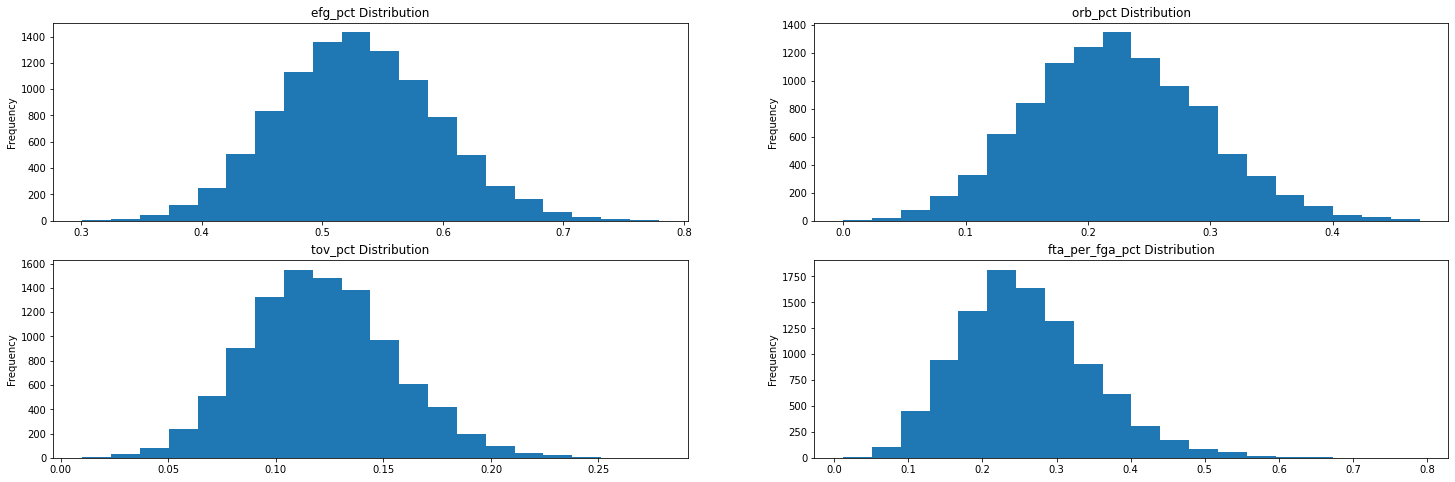

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(25, 8))
axes.resize(1, 4)
for ax, col in zip(axes[0], [x for x in model_df.columns if x != "pts" and x!="abbv"]):
    model_df[col].plot(kind="hist", bins=20, ax=ax)
    ax.set_title(f"{col} Distribution")

In [19]:
X = model_df.iloc[:, 1:-2].values
Y = model_df.iloc[:, -1:].values

In [21]:
X.shape

(9876, 4)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=11)

In [23]:
model_1 = LinearRegression(normalize=True)

In [24]:
model_1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [25]:
model_1.score(X_test, y_test)

0.7216376814989343

In [26]:
score_predictions_series = model_1.predict(X)
predictions = pd.DataFrame(zip(Y, score_predictions_series), columns=["Score", "y_hat"], dtype=np.float64)
predictions["Squared_Error"] = ((predictions["Score"] - predictions["y_hat"])**2)**.5

In [27]:
predictions.Squared_Error.describe()

count    9876.000000
mean        5.122668
std         4.198858
min         0.001507
25%         1.960943
50%         4.196963
75%         7.188837
max        48.188311
Name: Squared_Error, dtype: float64

Text(0.5, 0.98, 'Model 1 Error Distibution')

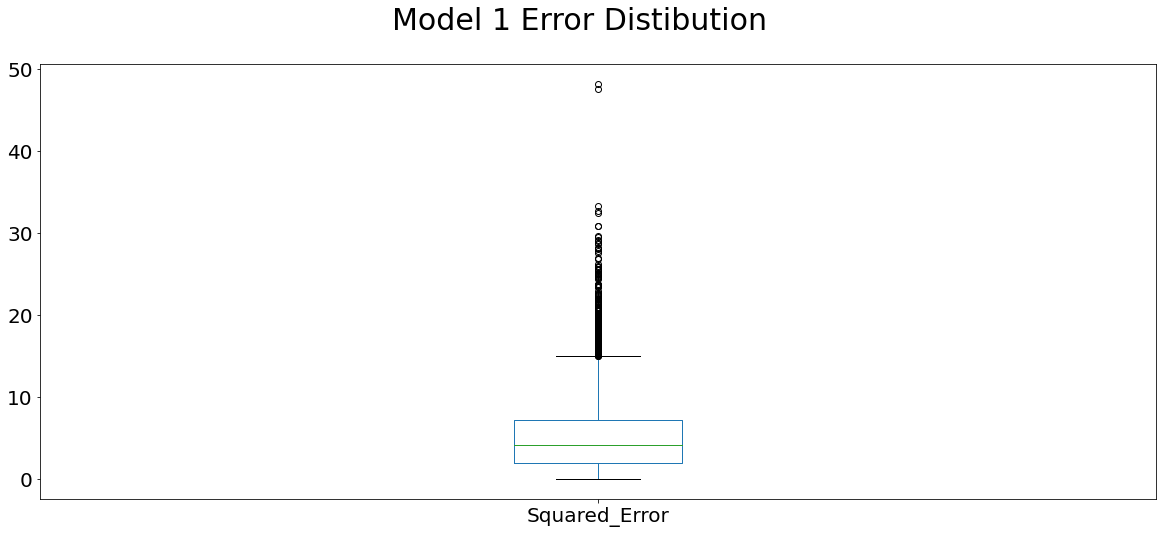

In [28]:
predictions.plot(y="Squared_Error", kind="box", figsize=(20, 8), fontsize=20)
plt.suptitle("Model 1 Error Distibution", size=30)

Text(0.5, 0.98, 'Model 1 Prediction (ŷ) vs. Real Scores')

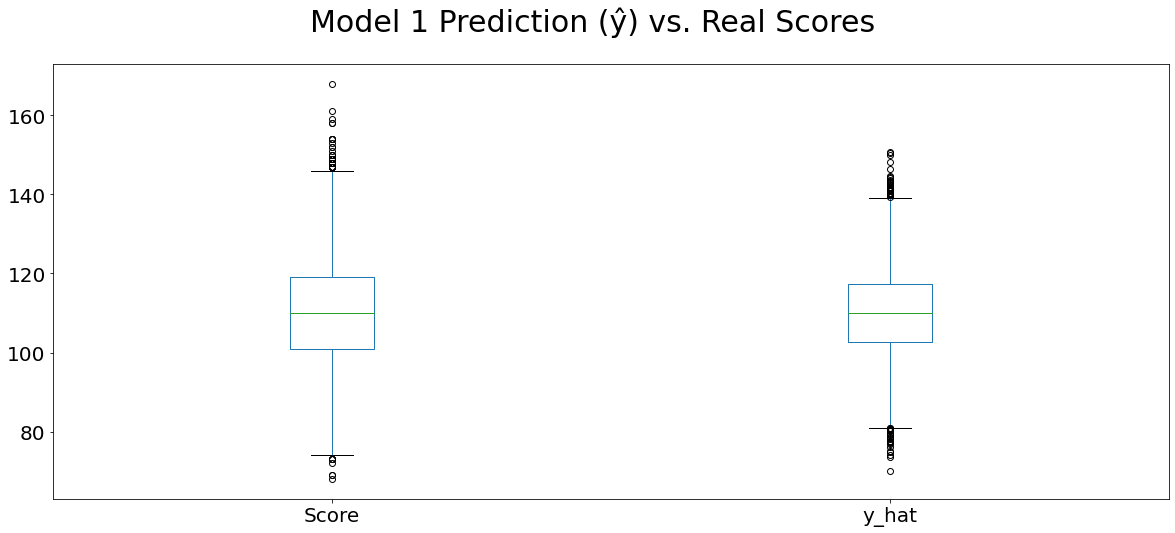

In [30]:
predictions.plot(y=["Score", "y_hat"], kind="box", figsize=(20, 8), fontsize=20)
plt.suptitle("Model 1 Prediction (ŷ) vs. Real Scores", size=30)

In [31]:
predictions.sort_values("Squared_Error", ascending=False).head(20)

,Score,y_hat,Squared_Error
1708,168.0,119.811689,48.188311
1709,161.0,113.399479,47.600521
670,148.0,114.715514,33.284486
1560,149.0,116.337071,32.662929
1294,148.0,115.545680,32.454320
4897,133.0,102.162763,30.837237
799,140.0,109.197334,30.802666
2371,154.0,124.381893,29.618107
671,147.0,117.438926,29.561074
4581,149.0,119.822092,29.177908


### Model 1 Evaluation
1. Basing A Score Prediction on Percentages Alone Still Leaves Me with A Large Amount of Outliers, some as high as 50.
2. Judging from the Distibution of Scores vs. My Prediction, the first model suffers the most from the highest scoring games. It can only adjust so far off the mean score to compensate for better shooting,
3. The Model Needs a Time Component to Factor In Overtime Games and Games With More Possessions.

## Model 2: Four Factors + Possession Adjustments
* There is no universally accepted parameter for possessions, but the above function is the way basketball reference tracks possessions (which can be confirmed by comparing the game_possessions column and their game pace statistic). 
    
* All possessions should lead to a scoring attempt via a shot (fga or fta), a continuation of the possession (or a possession 'reset' via an offensive rebound) or a change in possession via a turnover or a defensive rebound.
    
* Having a possession estimate should also help our regression model by feeding in a time variable to better adjust its scoring projections.
    * Since the first model only includes rates, the model assumes that all games take place over equivalent time, but for basketball the chance of a tie is more probable due to the frequency of scoring and all ties must be resolved through, in theory, unlimited overtimes until there is no longer one.
        


<AxesSubplot:>

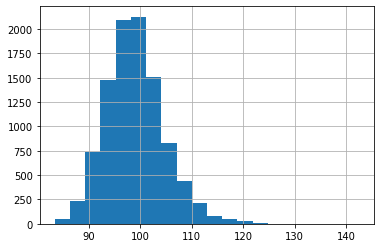

In [36]:
model_df.game_possessions.hist(bins=20)

In [37]:
X = model_df.iloc[:, 1:-1].values
Y = model_df.iloc[:, -1:].values

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=17)

In [41]:
model_2 = LinearRegression(normalize=True)

In [42]:
model_2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [43]:
model_2.score(X_test, y_test)

0.9576301591405864

In [61]:
model_2.coef_

array([[ 155.13962834,   50.12019717, -140.11060727,   20.30763086,
           1.09442528]])

In [44]:
predictions_2 = model_2.predict(X)

In [45]:
predictions_2_df = pd.DataFrame(zip(Y, predictions_2), columns=["Score", "y_hat"], dtype=np.float64)

In [46]:
predictions_2_df["Squared_Error"] = ((predictions_2_df["Score"] - predictions_2_df["y_hat"])**2)**.5

In [47]:
predictions_2_df.Squared_Error.describe()

count    9876.000000
mean        2.074947
std         1.598998
min         0.000023
25%         0.841411
50%         1.719310
75%         2.960148
max        11.217551
Name: Squared_Error, dtype: float64

Text(0.5, 0.98, 'Model 2 Error Distibution')

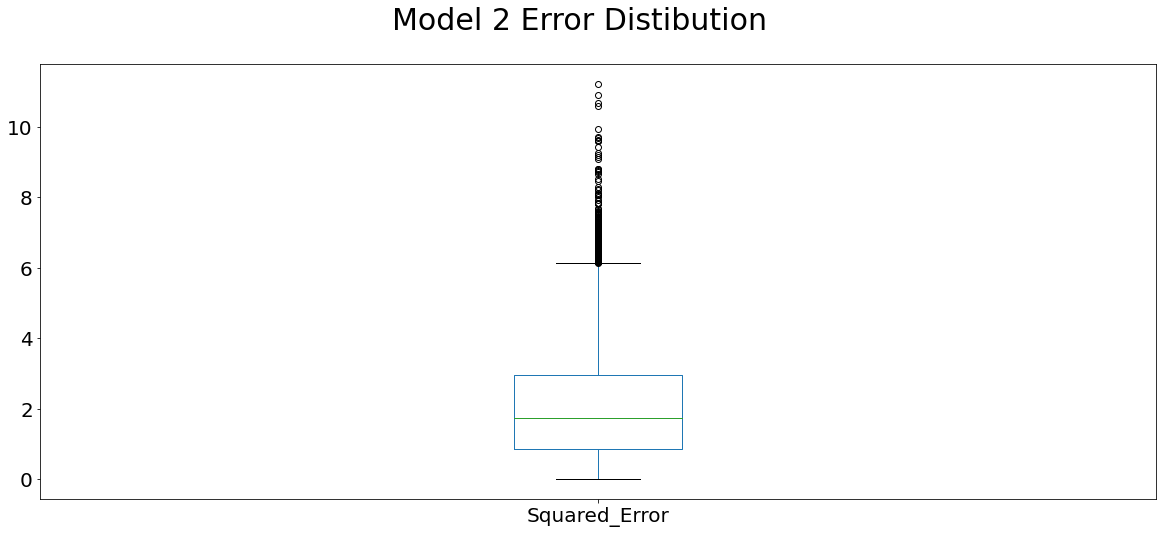

In [48]:
predictions_2_df.plot(y="Squared_Error", kind="box", figsize=(20, 8), fontsize=20)
plt.suptitle("Model 2 Error Distibution", size=30)

Text(0.5, 0.98, 'Model 2 Prediction (ŷ) vs. Real Scores')

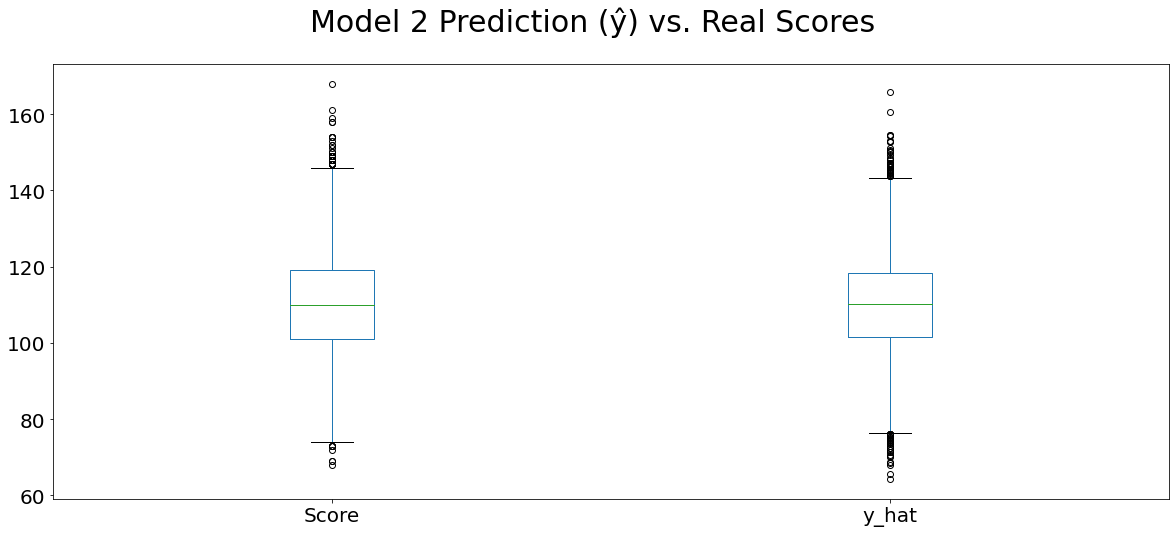

In [49]:
predictions_2_df.plot(y=["Score", "y_hat"], kind="box", figsize=(20, 8), fontsize=20)
plt.suptitle("Model 2 Prediction (ŷ) vs. Real Scores", size=30)

Text(0.5, 1.0, 'Comparison of the Distribution of the Squared Errors for Both Models')

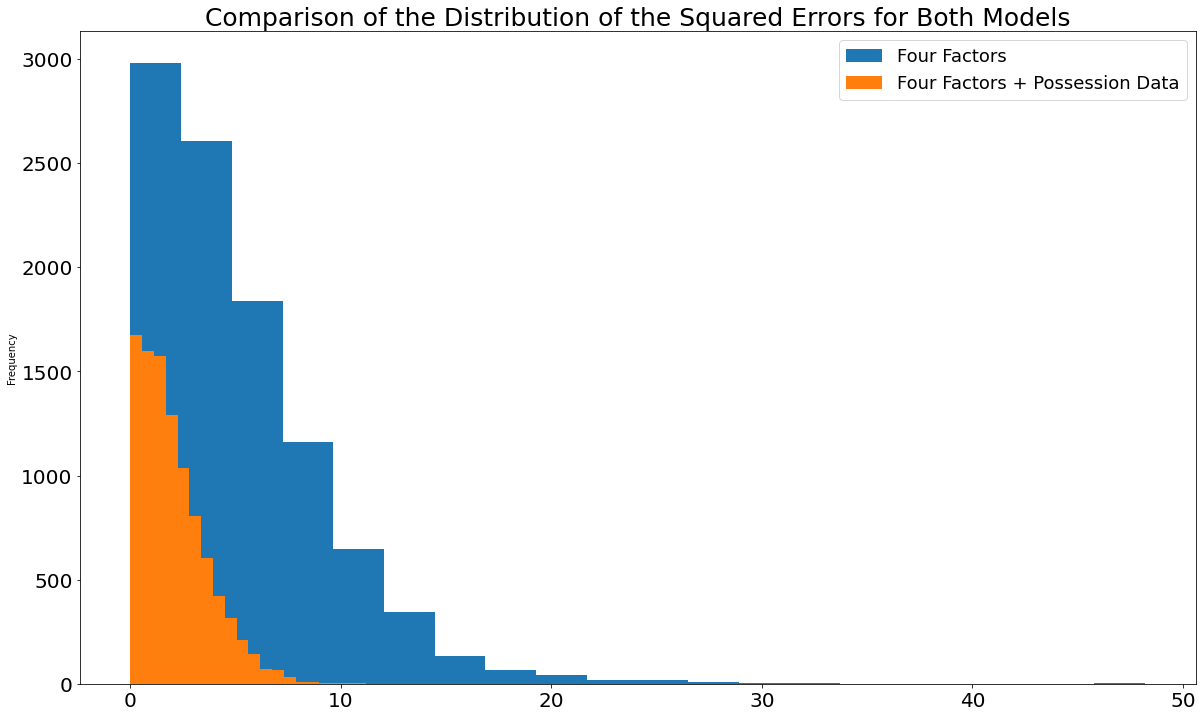

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
predictions.Squared_Error.plot(kind="hist", ax=ax, fontsize=20, bins=20)
predictions_2_df.Squared_Error.plot(kind="hist", ax=ax, bins=20)
ax.legend(["Four Factors", "Four Factors + Possession Data"], fontsize=18)
ax.set_title("Comparison of the Distribution of the Squared Errors for Both Models", fontsize=25)

<AxesSubplot:title={'center':'Model 1'}, xlabel='Squared_Error', ylabel='Score'>

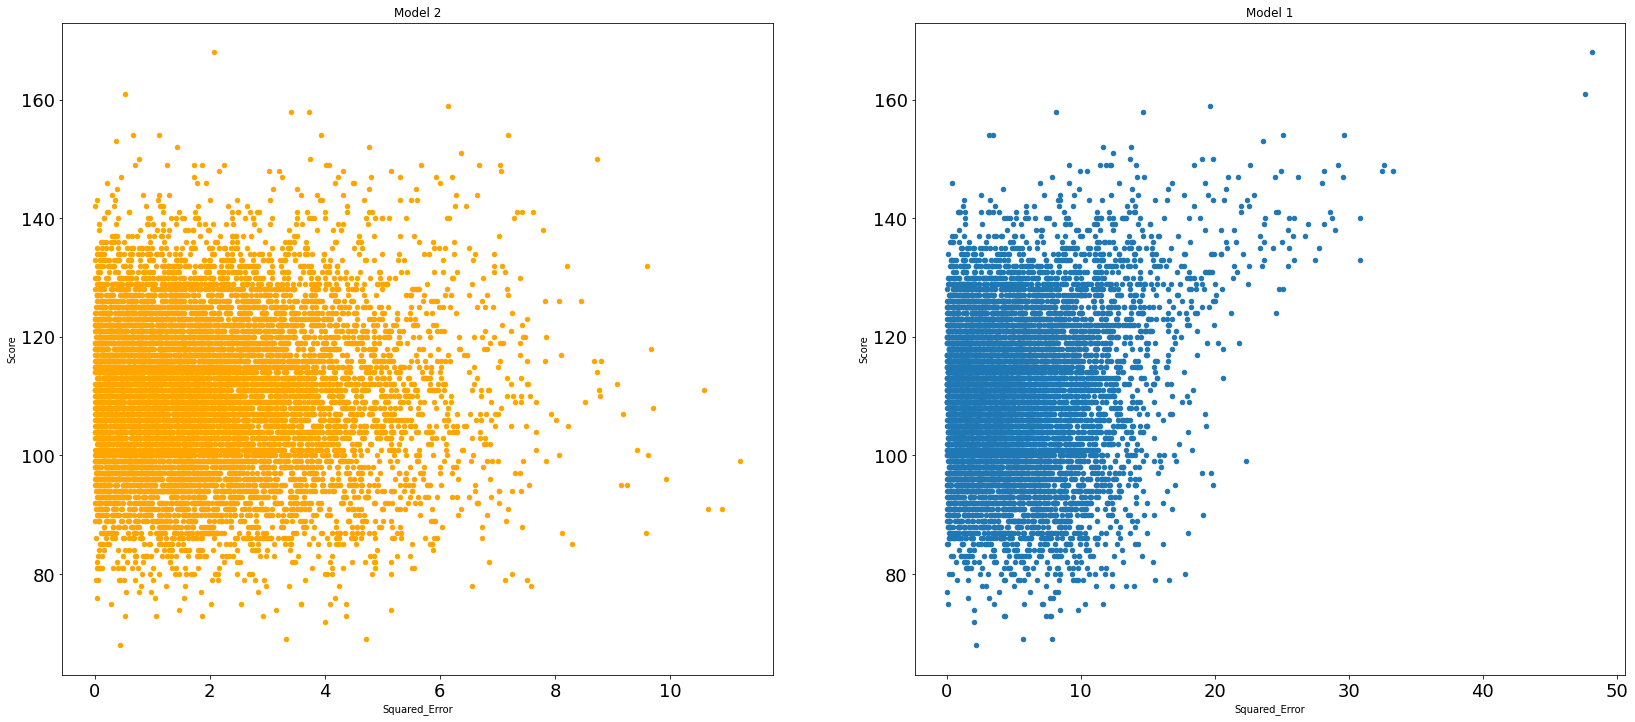

In [51]:
# Model 2's Residuals Show An Even Scatter and No Fanning Pattern; Model 1's Residuals Show A Fanning Pattern Indicating Worse Predictions for Higher Scores
fig, ax = plt.subplots(1, 2, figsize=(28, 12))
predictions_2_df.plot(kind="scatter", x="Squared_Error", y="Score", color="orange", ax=ax[0], title="Model 2", fontsize=18)
predictions.plot(kind="scatter", x="Squared_Error", y="Score", ax=ax[1], title="Model 1", fontsize=18)

In [52]:
model_df.corr()

,efg_pct,orb_pct,tov_pct,fta_per_fga_pct,game_possessions,pts
efg_pct,1.000000,-0.059725,0.117875,-0.024585,0.018471,0.742736
orb_pct,-0.059725,1.000000,0.017100,0.003023,-0.122318,0.164237
tov_pct,0.117875,0.017100,1.000000,0.100628,0.126815,-0.198695
fta_per_fga_pct,-0.024585,0.003023,0.100628,1.000000,0.143431,0.160461
game_possessions,0.018471,-0.122318,0.126815,0.143431,1.000000,0.447469
pts,0.742736,0.164237,-0.198695,0.160461,0.447469,1.000000


<AxesSubplot:ylabel='Frequency'>

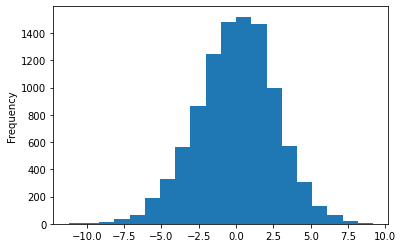

In [58]:
predictions_2_df.assign(Error = lambda x: x.Score - x["y_hat"]).Error.plot(kind="hist", bins=20)

<AxesSubplot:ylabel='Frequency'>

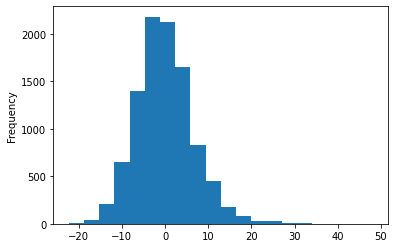

In [60]:
predictions.assign(Error = lambda x: x.Score - x["y_hat"]).Error.plot(kind="hist", bins=20)

In [73]:
engine = sql.create_engine("sqlite:///../data/interim/market.db")
conn = engine.connect()

In [74]:
df_timeseries = pd.read_sql("SELECT * FROM timeseries", con=conn, parse_dates="timestamp")
df_markets = pd.read_sql("SELECT team_abbv, book, moneyline, spread, spread_odds, total, over_odds, under_odds, game_id FROM market_summary", con=conn)
df_gamecodes =  pd.read_sql("SELECT * FROM results", con=conn, parse_dates="date")
conn.close()

In [82]:
df_markets[lambda x: x.game_id == "1026698"]

,team_abbv,book,moneyline,spread,spread_odds,total,over_odds,under_odds,game_id
51752,CHR,Opening,333.0,9.5,-110.0,222.5,-110.0,-110.0,1026698
51754,TOR,Opening,-500.0,-9.5,-110.0,222.5,-110.0,-110.0,1026698
51756,CHR,BetOnline,350.0,8.5,-109.0,225.0,-105.0,-115.0,1026698
51758,TOR,BetOnline,-420.0,-8.5,-111.0,225.0,-105.0,-115.0,1026698
51759,CHR,Intertops,320.0,8.5,-110.0,225.0,-105.0,-115.0,1026698
51761,TOR,Intertops,-410.0,-8.5,-110.0,225.0,-105.0,-115.0,1026698
51762,CHR,SportsBetting,350.0,8.5,-109.0,225.0,-105.0,-115.0,1026698
51763,TOR,SportsBetting,-420.0,-8.5,-111.0,225.0,-105.0,-115.0,1026698
51764,CHR,BetNow,340.0,9.0,-110.0,224.5,-110.0,-110.0,1026698
51766,TOR,BetNow,-425.0,-9.0,-110.0,224.5,-110.0,-110.0,1026698


In [71]:
df_markets

,team_abbv,book,moneyline,spread,spread_odds,total,over_odds,under_odds,game_id
0,SAC,Opening,305.0,10.0,-110.0,220.0,-110.0,-110.0,1459841
1,UTA,Opening,-455.0,-10.0,-110.0,220.0,-110.0,-110.0,1459841
2,SAC,BOVADA,310.0,9.0,-110.0,223.0,-110.0,-110.0,1459841
3,UTA,BOVADA,-415.0,-9.0,-110.0,223.0,-110.0,-110.0,1459841
4,SAC,BetOnline,340.0,9.0,-106.0,223.0,-110.0,-110.0,1459841
...,...,...,...,...,...,...,...,...,...
73295,PHO,MyBookie,475.0,10.0,-110.0,209.0,-110.0,-110.0,894160
73296,BOS,GTBets,-691.0,-10.0,-111.0,209.0,-107.0,-108.0,894160
73297,PHO,GTBets,492.0,10.0,-108.0,209.0,-107.0,-108.0,894160
73298,BOS,SkyBook,-662.0,-10.0,-110.0,208.5,-110.0,-110.0,894160


In [84]:
df_timeseries

,index,book,spread_line,spread_odds,total_line,over_odds,game_id,timestamp
0,0,BOVADA,-7.0,-110.0,224.5,-110.0,1459741,2021-10-30 08:10:27
1,1,BOVADA,-7.0,-110.0,223.5,-110.0,1459741,2021-10-30 08:35:12
2,2,BOVADA,-7.0,-110.0,224.0,-110.0,1459741,2021-10-30 15:43:56
3,3,BOVADA,-7.0,-110.0,224.5,-110.0,1459741,2021-10-30 15:50:00
4,4,BOVADA,-7.0,-110.0,223.5,-110.0,1459741,2021-10-30 16:06:15
...,...,...,...,...,...,...,...,...
763519,763519,SportsBetting,10.0,-107.0,208.0,-110.0,894160,2018-03-26 21:27:53
763520,763520,SportsBetting,10.0,-105.0,208.5,-110.0,894160,2018-03-26 21:38:19
763521,763521,SportsBetting,10.0,-105.0,208.5,-115.0,894160,2018-03-26 21:43:27
763522,763522,SportsBetting,10.0,-105.0,209.0,-110.0,894160,2018-03-26 21:58:51


In [95]:
model_pred_and_errors = model_df.merge(predictions_2_df.loc[:, ["y_hat", "Squared_Error"]], right_index=True, left_index=True)\
    .merge(predictions.loc[:, ["y_hat", "Squared_Error"]], left_index=True, right_index=True, suffixes=("_m2", "_m1"))

In [114]:
game_predictions_lr = pd.concat([model_pred_and_errors.iloc[::2, 7:].reset_index(drop=True),model_pred_and_errors.iloc[1::2, 7:].reset_index(drop=True)], axis=1)

In [116]:
game_predictions_lr.columns 

Index(['y_hat_m2', 'Squared_Error_m2', 'y_hat_m1', 'Squared_Error_m1',
       'y_hat_m2', 'Squared_Error_m2', 'y_hat_m1', 'Squared_Error_m1'],
      dtype='object')

In [117]:
game_predictions_lr.columns = ['m2_proj_home', 'm2_error_home', 'm1_proj_home', 'm1_error_home',
       'm2_proj_away', 'm2_error_away', 'm1_proj_away', 'm1_error_away']

In [122]:
df_results.shape[0] == game_predictions_lr.shape[0]

True

In [124]:
results_and_projections = df_results.merge(game_predictions_lr, left_index=True, right_index=True)

In [125]:
df_markets

,team_abbv,book,moneyline,spread,spread_odds,total,over_odds,under_odds,game_id
0,SAC,Opening,305.0,10.0,-110.0,220.0,-110.0,-110.0,1459841
1,UTA,Opening,-455.0,-10.0,-110.0,220.0,-110.0,-110.0,1459841
2,SAC,BOVADA,310.0,9.0,-110.0,223.0,-110.0,-110.0,1459841
3,UTA,BOVADA,-415.0,-9.0,-110.0,223.0,-110.0,-110.0,1459841
4,SAC,BetOnline,340.0,9.0,-106.0,223.0,-110.0,-110.0,1459841
...,...,...,...,...,...,...,...,...,...
73295,PHO,MyBookie,475.0,10.0,-110.0,209.0,-110.0,-110.0,894160
73296,BOS,GTBets,-691.0,-10.0,-111.0,209.0,-107.0,-108.0,894160
73297,PHO,GTBets,492.0,10.0,-108.0,209.0,-107.0,-108.0,894160
73298,BOS,SkyBook,-662.0,-10.0,-110.0,208.5,-110.0,-110.0,894160


In [158]:
games_and_id = df_gamecodes.loc[:, ["home_abbv", "away_abbv", "game_id"]]

In [424]:
# Transform Team Markets to Game
open_and_closing_mkts = games_and_id.merge(df_markets, left_on=["home_abbv", "game_id"], right_on=["team_abbv", "game_id"])\
    .merge(df_markets.loc[:, ["team_abbv", "moneyline", "spread", "spread_odds","book", "game_id"]], left_on=["away_abbv", "game_id", "book"], right_on=["team_abbv", "game_id", "book"], suffixes=("_home", "_away"))

In [425]:
# Rearrange and Pari Down Redundant Columns
open_and_closing_mkts =open_and_closing_mkts.loc[:, ['home_abbv', 'away_abbv', 'book',
       'moneyline_home', 'moneyline_away', 'spread_home', 'spread_odds_home', 'spread_away', 'spread_odds_away',
       'total', 'over_odds', 'under_odds', "game_id"]]

In [426]:
open_and_closing_mkts.head()

,home_abbv,away_abbv,book,moneyline_home,moneyline_away,spread_home,spread_odds_home,spread_away,spread_odds_away,total,over_odds,under_odds,game_id
0,TOR,DAL,Opening,-777.0,622.0,-10.5,-110.0,10.5,-110.0,229.0,-110.0,-110.0,1026833
1,TOR,DAL,BetOnline,-850.0,635.0,-11.5,-105.0,11.5,-115.0,221.5,-103.0,-117.0,1026833
2,TOR,DAL,Intertops,-900.0,600.0,-11.5,-110.0,11.5,-110.0,221.0,-110.0,-110.0,1026833
3,TOR,DAL,SportsBetting,-850.0,635.0,-11.5,-105.0,11.5,-115.0,221.5,-103.0,-117.0,1026833
4,TOR,DAL,BetNow,-930.0,615.0,-11.5,-110.0,11.5,-110.0,221.5,-110.0,-110.0,1026833


In [ ]:
actual_scores = df_results.loc[:, ["pts_home", "pts_away", "game_id"]]

In [ ]:
results_and_projections = results_and_projections.drop(["m2_proj_home", "m2_error_home", "m1_proj_home", "m1_error_home", "m2_proj_away", "m2_error_away", "m1_proj_away", "m1_error_away"], axis=1)

In [ ]:
# Need to Regenerate Model Predictions Due to a Bad Concatenation Somewhere Up Top
xs_1 = results_and_projections.loc[:, ["efg_pct_home", "orb_pct_home", "tov_pct_home", "fta_per_fga_pct_home"]].values
xs_2 = results_and_projections.loc[:, ["efg_pct_away", "orb_pct_away", "tov_pct_away", "fta_per_fga_pct_away"]].values

In [ ]:
home_array = model_1.predict(xs_1)
away_array = model_1.predict(xs_2)

In [ ]:
results_and_projections["m1_proj_home"] = home_array
results_and_projections["m1_proj_away"] = away_array

In [ ]:
xs_1 = results_and_projections.loc[:, ["efg_pct_home", "orb_pct_home", "tov_pct_home", "fta_per_fga_pct_home", "game_possessions"]].values
xs_2 = results_and_projections.loc[:, ["efg_pct_away", "orb_pct_away", "tov_pct_away", "fta_per_fga_pct_away", "game_possessions"]].values

In [ ]:
results_and_projections["m2_proj_home"] = model_2.predict(xs_1)
results_and_projections["m2_proj_away"] = model_2.predict(xs_2)

In [ ]:
results_and_projections["m2_proj_home"] = results_and_projections["m2_proj_home"].apply(round, ndigits=3)
results_and_projections["m2_proj_away"] = results_and_projections["m2_proj_away"].apply(round, ndigits=3)
results_and_projections["m1_proj_home"] = results_and_projections["m1_proj_home"].apply(round, ndigits=3)
results_and_projections["m1_proj_away"] = results_and_projections["m1_proj_away"].apply(round, ndigits=3)

In [550]:
# Transform American Odds Into Amount Earned Given Betting $100
def oddsFlip(american_odds):
    american_odds = float(american_odds)
    if american_odds < 0:
        return round((100/(abs(american_odds)))*100, 2)
    else:
        return american_odds 

In [756]:
def oddsToProb(american_odds):
    american_odds = float(american_odds)
    if american_odds < 0:
        return 100 / ((american_odds*-1) + 100)
    else:
        return american_odds / (american_odds + 100)

In [766]:
class ModelAnalyzer:
    def __init__(self, projections, markets, ground_truth, estimate, unit=100):
        self.projections = projections
        self.markets = markets
        self.ground_truth = ground_truth
        self.estimate = estimate
        self.unit = unit
        self.odds_matrix = None
        self.graded_picks = None

    # Decompose Markets Into Score Projections
    def transform_markets(self):
        self.markets["market_score_home"] = ((self.markets["spread_home"] * -1) / 2) + ((self.markets["total"]) / 2)
        self.markets["market_score_away"] = ((self.markets["spread_away"] * -1) / 2) + ((self.markets["total"]) / 2)
        self.market_projections = self.markets.loc[:, ["book", "market_score_home", "market_score_away", "game_id"]] 
        return None
    # Transform Score Projections Into Markets
    def scores_to_market(self):
        self.projected_markets = pd.DataFrame()
        self.projected_markets["game_id"] = self.projections.game_id
        self.projected_markets["proj_spread"] = ((self.projections[f"{self.estimate}_proj_home"] - self.projections[f"{self.estimate}_proj_away"]) * -1).apply(round, ndigits=3)
        self.projected_markets["proj_total"] = (self.projections[f"{self.estimate}_proj_home"] + self.projections[f"{self.estimate}_proj_away"]).apply(round, ndigits=3)
        self.projected_markets["proj_ml"] = (self.projections[f"{self.estimate}_proj_home"] > self.projections[f"{self.estimate}_proj_away"]).astype("int32")
        return None
    # Evaluate Wanted Markets Vs. Ground Truth
    def eval_markets(self):
        full_gmm = pd.DataFrame()
        self.ground_truth["real_total"] = self.ground_truth["pts_home"] + self.ground_truth["pts_away"]
        # will be in terms of home
        self.ground_truth["real_spread"] = (self.ground_truth["pts_home"] - self.ground_truth["pts_away"])*-1
        # Only Market That Grades The Same For All Markets Since it Is Concerned With Wins and Losses 
        self.ground_truth["ml_bin"] = (self.ground_truth["pts_home"] > self.ground_truth["pts_away"]).apply(lambda x: "W" if x else "L")
        for market in self.markets.book.unique():
            market_lines_df = self.markets.query(f"book == '{market}'")
            market_closing_lines = market_lines_df.loc[:, ["spread_home", "total", "game_id"]]
            market_odds = market_lines_df.loc[:, [x for x in market_lines_df.columns if "odds" in x or "moneyline" in x]]
            for am_odds in market_odds.columns:
                market_odds[am_odds] = market_odds[am_odds].apply(oddsFlip)

            market_closing_lines = market_closing_lines.merge(self.ground_truth, on=["game_id"])
            conditions_list = [(market_closing_lines.spread_home == market_closing_lines.real_spread), (market_closing_lines.spread_home < market_closing_lines.real_spread),
            (market_closing_lines.spread_home > market_closing_lines.real_spread)]
            market_closing_lines["spread_bin"]  = np.select(condlist=conditions_list, choicelist=["P", "L", "W"])
            conditions_list = [(market_closing_lines.total == market_closing_lines.real_total), (market_closing_lines.total < market_closing_lines.real_total),
            (market_closing_lines.total > market_closing_lines.real_total)]
            market_closing_lines["over_under_bin"] = np.select(condlist=conditions_list, choicelist=["P", "O", "U"])
            market_closing_lines["book"] = market
            full_gmm = pd.concat([full_gmm, market_closing_lines.loc[:, ["ml_bin", "over_under_bin", "spread_bin", "book", "game_id"]]], axis=0).reset_index(drop=True)
        self.full_book_eval = full_gmm
        return None
    # Evaluate (Market vs. Truth) vs. (Projected Market vs. Actual Market)
    def eval_model(self, book):
        actual_mkt = self.markets.query(f"book == '{book}'")
        mkt_comparison = actual_mkt.merge(self.projected_markets, on="game_id")
        mkt_comparison["spread_pick"] = (mkt_comparison["proj_spread"] < mkt_comparison["spread_home"]).apply(lambda x: "W" if x else "L")
        mkt_comparison["total_pick"] = (mkt_comparison["proj_total"] < mkt_comparison["total"]).apply(lambda x: "U" if x else "O") # You Think the Total Will Go Under
        mkt_comparison["book"] = book
        mkt_comparison = mkt_comparison.rename(columns={"proj_ml": "ml_pick"})
        mkt_comparison.ml_pick = mkt_comparison.ml_pick.apply(lambda x: "W" if x else "L")
        odds_df = mkt_comparison.loc[:, ["moneyline_home", "moneyline_away", "spread_odds_home", "spread_odds_away", "over_odds", "under_odds", "game_id"]]
        mkt_comparison = mkt_comparison.loc[:, ["spread_pick", "total_pick", "ml_pick", "game_id"]]
        self.prob_matrix = odds_df.copy(deep=True)
        for col in [c for c in odds_df.columns if c != "game_id"]:
            odds_df[col] = odds_df[col].apply(oddsFlip)
        odds_matrix = pd.DataFrame()
        odds_matrix["ml_odds"] = np.where(mkt_comparison.ml_pick == "W", odds_df.moneyline_home, odds_df.moneyline_away)
        odds_matrix["spread_odds"] = np.where(mkt_comparison.spread_pick == "W", odds_df.spread_odds_home, odds_df.spread_odds_away)
        odds_matrix["total_odds"] = np.where(mkt_comparison.ml_pick == "O", odds_df.over_odds, odds_df.under_odds)
        odds_matrix["book"] = book
        odds_matrix = odds_matrix.fillna(0)
        self.odds_matrix = odds_matrix
        [(mkt_comparison.spread_pick == "W"), (mkt_comparison.spread_pick == "L")]
        [(mkt_comparison.spread_pick == "O"), (mkt_comparison.spread_pick == "U")]
        mkt_grades = self.full_book_eval.query(f"book == '{book}'")
        grader = mkt_grades.merge(mkt_comparison, on="game_id")
        grader["ml_pk"] = (grader["ml_bin"] == grader["ml_pick"]).apply(lambda x: "W" if x else "L")
        grader["spread_pk"] = np.select(condlist=[grader["spread_bin"] == "P", (grader["spread_bin"] == grader["spread_pick"]), (grader["spread_bin"] != grader["spread_pick"])], choicelist=["P", "W", "L"])
        grader["total_pk"] = np.select(condlist=[grader["over_under_bin"] == "P", (grader["over_under_bin"] == grader["total_pick"]), (grader["over_under_bin"] != grader["total_pick"])], choicelist=["P", "W", "L"])
        self.graded_picks = grader.loc[:, ["ml_pk", "spread_pk", "total_pk", "book", "game_id"]]
        return None
    
    def create_winnings(self, book, unit):
        self.unit = unit
        self.winnings_matrix = pd.DataFrame()
        _odds = self.odds_matrix.query(f"book == '{book}'")
        for c in [x for x in _odds.columns if x != "book"]:
            _odds[c] = (_odds[c] / 100).astype("float32").apply(round, ndigits=4)
        _grades = self.graded_picks.query(f"book == '{book}'").loc[:, ["ml_pk", "spread_pk", "total_pk"]]
        for market in [m for m in _grades.columns]:
            self.winnings_matrix[market.replace("pk", "winnings")] = np.select([_grades[market]=="W", _grades[market]=="P", _grades[market]=="L"], [1+_odds[market.replace("pk", "odds")], 1, -1]) 
        self.winnings_matrix = self.winnings_matrix * self.unit
        self.winnings_matrix["book"] = book
        return self.winnings_matrix

    def create_probability_matrix(self):
        for col in [x for x in self.prob_matrix.columns if x != "game_id"]:
            self.prob_matrix[col] = self.prob_matrix[col].apply(oddsToProb).astype("float32")
        return self.prob_matrix

    


In [568]:
cls_mkt = open_and_closing_mkts.copy(deep=True)
cls_ts = df_timeseries.copy(deep=True)
cls_proj = results_and_projections.copy(deep=True)
cls_groundtruth = actual_scores.copy(deep=True)

In [767]:
sample = ModelAnalyzer(cls_proj, cls_mkt, cls_groundtruth, "m2", unit=25)

In [768]:
sample.eval_markets()

In [769]:
sample.transform_markets()

In [770]:
sample.scores_to_market()

In [771]:
sample.eval_model("BetOnline")

In [772]:
sample.odds_matrix

,ml_odds,spread_odds,total_odds,book
0,11.76,95.24,85.47,BetOnline
1,67.57,90.91,95.24,BetOnline
2,9.09,88.50,95.24,BetOnline
3,25.97,88.50,87.72,BetOnline
4,415.00,93.46,105.00,BetOnline
...,...,...,...,...
3412,47.62,86.96,95.24,BetOnline
3413,172.00,92.59,95.24,BetOnline
3414,62.50,92.59,94.34,BetOnline
3415,81.30,99.01,97.09,BetOnline


In [773]:
sample.create_winnings("BetOnline", 25)

,ml_winnings,spread_winnings,total_winnings,book
0,27.9400,-25.0000,-25.0000,BetOnline
1,41.8925,47.7275,48.8100,BetOnline
2,27.2725,-25.0000,48.8100,BetOnline
3,31.4925,47.1250,46.9300,BetOnline
4,128.7500,48.3650,51.2500,BetOnline
...,...,...,...,...
3412,36.9050,-25.0000,48.8100,BetOnline
3413,68.0000,48.1475,48.8100,BetOnline
3414,40.6250,48.1475,48.5850,BetOnline
3415,45.3250,49.7525,49.2725,BetOnline


In [774]:
sample.create_probability_matrix()

,moneyline_home,moneyline_away,spread_odds_home,spread_odds_away,over_odds,under_odds,game_id
0,0.105263,0.863946,0.487805,0.465116,0.492611,0.460829,1026833
1,0.403226,0.561404,0.476190,0.476190,0.465116,0.487805,1026598
2,0.083333,0.885714,0.469484,0.483092,0.465116,0.487805,1026528
3,0.206186,0.764706,0.483092,0.469484,0.485437,0.467290,1026763
4,0.163934,0.805825,0.469484,0.483092,0.444444,0.512195,1027523
...,...,...,...,...,...,...,...
3412,0.322581,0.642857,0.487805,0.465116,0.465116,0.487805,1347636
3413,0.632353,0.336700,0.480769,0.471698,0.465116,0.487805,1347606
3414,0.384615,0.583333,0.480769,0.471698,0.467290,0.485437,1412811
3415,0.448430,0.507389,0.497512,0.456621,0.460829,0.492611,1412496


In [579]:
sampler = ModelAnalyzer(cls_proj, cls_mkt, cls_groundtruth, "m2")